In [1]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd

from typing import Union

from matplotlib import pyplot as plt
from matplotlib import colorbar as mbar
import seaborn as sns

from scipy.ndimage import gaussian_filter as smooth
from sklearn.preprocessing import StandardScaler as Scaler

from scipy.stats import mannwhitneyu as mnu

from sklearn.metrics.pairwise import cosine_similarity as cosine
from scipy.stats import pearsonr as pearson
from scipy.stats import spearmanr as spearman
from scipy.stats import kendalltau as kendall

from scipy.stats import permutation_test
from scipy.stats import norm

from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

from scipy.io import loadmat

import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

## Definitions ##

In [2]:
def movavg(input, win=[], step=[]):
    '''
    Args:
        input: matrix of input data, with shape (Neurons,Stimuli,Timepoints)
        win:   size of the window for moving averge
        step:  step size for moving forward
    Returns:
        output:     matrix of output data, with shape (Neurons,Stimuli,Timepoints),
                    where Timepoints are following the moving average process
        timestamps: (N,) vector of timepoints, corresponding to the output data, 
                    where N is the number of timepoints following the moving average process
    '''

    if not win: win = input.shape[2] // 25
    if not step: step = win // 10
    
    bins = [np.arange(0,input.shape[2]-win+1,step), 
            np.arange(win, input.shape[2]+1, step)]
    
    nbins = np.array(bins).shape[1]
    output = np.nan * np.zeros((input.shape[0], input.shape[1], nbins))

    timestamps = []
    counter_bin = 0
    for bin_st, bin_end in tqdm(zip(bins[0],bins[1])):
        timestamps.append(np.nanmean([bin_st, bin_end]))
        output[:,:,counter_bin] = np.nanmean(input[:,:,bin_st:bin_end], axis=2)
        counter_bin += 1

    return output, np.array(timestamps)


def mk_repmat_kernel(input_ls, plot_kernel=False):
    '''
    Args:
        input_ls:    list with the number of samples per condition, i.e., 
                     the list size is the number of categories
        plot_kernel: if True, the created kernel will be plotted
    Returns:
        kernel: (N,N) theoretical ground-truth representatational matrix,
                where N is the total number of samples
    '''

    kernel = np.zeros([sum(input_ls),sum(input_ls)])
    counter_ind = 0
    for i in input_ls:
        inds = np.arange(counter_ind, counter_ind+i)
        counter_ind += i
        kernel[np.ix_(inds,inds)] = 1
        
    if plot_kernel:
        plt.figure(figsize=(2,2))
        plt.imshow(kernel, cmap='coolwarm')
        plt.axis('off')

    return kernel


def mk_repmat_data(input_data, sim_method='cosine', print_info=False):
    '''
    Args:
        input_data: matrix of input data, with shape (Neurons,Stimuli)
        sim_method: method for creating representatational matrix
                    cosine, for cosine similarity
                    spearman, for spearman correlation 
        print_info: if True, the progression will be printed
    Returns:
        repmat: (N,N) representatational matrix, where N is the total number of samples
    '''

    if sim_method=='cosine':
        repmat = cosine(input_data.T)
    elif sim_method=='spearman':
        CorRows = []
        for stim_i in range(input_data.shape[1]):
            CorCols = []
            for stim_j in range(input_data.shape[1]):
                CorCols.append(spearman(input_data[:,stim_i], input_data[:,stim_j])[0])

                if print_info:
                    print('stim_i: ' + str(((stim_i+1)/input_data.shape[1])*100) +
                          ' | ' + 'stim_j: ' + str(((stim_j+1)/input_data.shape[1])*100))

            CorRows.append(CorCols)
        repmat = np.array(CorRows)
    
    return repmat

def mk_total_repmat_data(input_data, sim_method='cosine'):
    '''
    Args:
        input_data: matrix of input data, with shape (Neurons,Stimuli,Timepoints)
        sim_method: method for creating representatational matrix
                    cosine, for cosine similarity
                    spearman, for spearman correlation 
    Returns:
        total_repmat: (N,N,T) representatational matrix, where N is the total number of samples and
                      T is the number of time-points
    '''

    total_repmat = []
    for iTime in range(input_data.shape[2]):
        tmp_retmat = mk_repmat_data(input_data=input_data[:,:,iTime], sim_method=sim_method, print_info=False)
        total_repmat.append(tmp_retmat)
    return np.transpose(np.array(total_repmat), (1,2,0))


def plot_repmat(input_repmat, plot_sz=3, show_clb=False, titles=[], colormap='coolwarm', cbar_label='Cosine Similarity (au)', fig_title=''):
    '''
    Args:
        input_repmat: (M,N,N) representatational matrices, where M is the number of conditions and
                      N is the total number of samples
        plot_sz:      size of the generated plot
        show_clb:     if True, colorbar will be shown
        titles:       list of titles of each representatational matrix
        colormap:     colormap for the generated plot
        cbar_label:   colorbar label
    Returns:
        none
    '''

    if not titles: titles=['']*len(input_repmat)
    if show_clb==True:
        fig, axs = plt.subplots(nrows=1, ncols=len(input_repmat)+1, figsize=(3*plot_sz,plot_sz),  dpi=500)
    else:
        fig, axs = plt.subplots(nrows=1, ncols=len(input_repmat), figsize=(3*plot_sz,plot_sz),  dpi=500)

    for ax,repmat,tle in zip(axs.flatten(), input_repmat, titles):
        ax.imshow(repmat, cmap=colormap)
        ax.set_title(tle, fontsize=5)
        ax.axis('off')
    if show_clb:
        clb = mbar.ColorbarBase(ax=axs[-1], cmap=colormap, orientation="vertical", ticks=[0,1])
        clb.set_label(cbar_label, fontsize=plot_sz*3)
        clb.outline.set_visible(False)
    plt.suptitle(fig_title, fontsize=plot_sz*10)


def m_plot(input_data, colors, error_method='sem', smooth_win=0, labels=[], plot_title='', timepoints=[], figure_size=(8,3)):
    '''
    Args:
        input_data:   (N,M,T) matrix of input data, (Conditions,Samples,Timepoints)
        colors:       (N,4) matrix of colors for the generated plots in [R,G,B,FaceAlpha] format,
                      where N is the number of conditions. FaceAlpha in the scale=[0-255]
        error_method: variation metric ('sem' & 'std')
        smooth_win:   smoothing window
        
        labels:       (N,) list of labels for the generated plots, where N is the number of conditions
        plot_title:   title of the generated plot
        timepoints:   (N,) vaetor of timepoints
        figure_size:  two-item tuple containing width and height of the figure
    Returns:
        none
    '''

    colors = np.array(colors) / np.array(255)
    if not labels: labels=['']*len(input_data)
    timepoints = np.array(timepoints)
    if timepoints.size==0: timepoints = np.arange(0,input_data[0].shape[1])
    
    plt.figure(figsize=figure_size)
    # sns.set_style('darkgrid')
    for i,Cond in enumerate(input_data):
        data_ave = smooth(np.nanmean(Cond, axis=0), smooth_win, axes=0)
        data_std = smooth(np.nanstd(Cond, axis=0), smooth_win, axes=0)
        
        if error_method=='sem':
            error_up  = data_ave + (data_std / np.sqrt(Cond.shape[0]))
            error_low = data_ave - (data_std / np.sqrt(Cond.shape[0]))
        elif error_method=='std':
            error_up  = data_ave + data_std
            error_low = data_ave - data_std

        plt.fill_between(timepoints, error_up, error_low, color=colors[i], label='_nolegend_')
        plt.plot(timepoints, data_ave, color=colors[i,:3], lw=3, label=labels[i])
    
    ylim = plt.ylim()
    plt.fill_between([0, 80], [ylim[0], ylim[0]], [ylim[1], ylim[1]], color='gray', alpha=.2, edgecolor=None)
    plt.legend(frameon=False, fontsize=10)
    plt.title(plot_title)
    plt.tight_layout()


def compute_similarity(data_mat, kernel_mat, sim_method='kendall'):
    '''
    Args:
        data_mat:   (N,N) representatational matrix created from data,
                    where N is the number of conditions
        kernel_mat: (N,N) theoretical ground-truth representatational matrix,
                    where N is the number of conditions
        sim_method: method to calculate similarity
    Returns:
        similarity: similarity value between data_mat and kernel_mat
    '''
    if sim_method!='kendall':
        data_mat = data_mat.reshape((data_mat.shape[0]**2,1))
        kernel_mat = kernel_mat.reshape((kernel_mat.shape[0]**2,1))

    if sim_method=='kendall':
        similarity = kendall(data_mat, kernel_mat)[0]
    elif sim_method=='spearman':
        similarity = spearman(data_mat, kernel_mat)[0]
    elif sim_method=='pearson':
        similarity = pearson(data_mat, kernel_mat)[0]

    return similarity


def compute_rsa(data_input, conds_ls=[], sp_kernel=[], sim_method='kendall', print_info=False):
    '''
    Args:
        data_input: matrix of input data, with shape (Neurons,Stimuli,Timepoints)
        conds_ls:   list with the number of samples per condition, i.e., the list size is the number
                    of categories, and each item is the number of stimuli per that category
        sp_kernel:  (N,N) representatational matrix, i.e., specific kernel,
                    where N is the number of stimuli
        sim_method: method to calculate similarity
        print_info: if True, the progression will be printed
    Returns:
        rsa: (N,) vector of similarity values, where N is the number of timepoints
    '''
    
    if not sp_kernel: kernel = mk_repmat_kernel(conds_ls)
    elif not conds_ls: kernel = sp_kernel

    rsa = []
    for i_time in range(data_input.shape[2]):
        temp_mat = []
        temp_mat = mk_repmat_data(data_input[:,:,i_time])
        rsa.append(compute_similarity(temp_mat, kernel, sim_method))

        if print_info:
            print('% ' + str(((i_time+1)/data_input.shape[2])*100))
            
    return np.array(rsa)


def rand_idx_gen(cyles, cat_inds, stim_num, replacement=False):
    '''
    Args:
        cyles:       number repetitions or cycles
        cat_inds:    (N,) list of indices in each category/condition, where N is the number of categories/conditions,
                     and each item in the list is a np.array of indices for that category/condition.
        stim_num:    number of samples for each category/condition
        replacement: if True, sampling will be with replacement
    Returns:
        idx_rand: (N,M) np.array of the generated random indices, (cyles,cat_inds*stim_num)
    '''
    np.random.seed(15)
    idx_rand = []

    for iCycle in range(cyles):
        tmp_rand_tdx = []
        for i,iCat in enumerate(cat_inds):
            tmp_rand_tdx = np.concatenate((tmp_rand_tdx, iCat[np.random.choice(iCat.shape[0], stim_num, replace=replacement)]), axis=0)
        idx_rand.append(tmp_rand_tdx)

    return np.array(idx_rand).astype('int')


def rsaGranger(src: np.array, dst: np.array, n: int, k: int, mdl=Ridge, print_info=False, timepoints=[]) -> Union[np.array, dict]:
    '''
    Args:
        src:        (N,N,T) array of representatational matrices over time for the sender area, where T is time and 
                    each (N,N) is a representatational matrix at a time-point, in which N is the total number of stimuli
        dst:        same as "src", for the reciever area. "src" and "dst" must have the same shape
        n:          ---
        k:          ---
        mdl:        ---
        print_info: if True, the progression will be printed
        timepoints: (N,) np.array vector of timepoints
    Returns:
        (N,) value of granger predictivity for "src-to-dst" direction
        (N,) vector of new timepoints
    '''

    assert((src.shape == dst.shape))
    timepoints = np.array(timepoints)
    if timepoints.size==0: timepoints = np.arange(0,src.shape[2])

    triu = np.triu_indices(src.shape[0], k=1)
    time_stamps, unex_r, unex_f, norm_w = [], [], [], []

    for iTime in range(n+k, src.shape[2]):
        
        y = dst[triu[0], triu[1], iTime]
        x_r = dst[triu[0], triu[1], (iTime-n-k):(iTime-k+1)]
        x_f = np.concatenate((
            dst[triu[0], triu[1], (iTime-n-k):(iTime-k+1)], 
            src[triu[0], triu[1], (iTime-n-k):(iTime-k+1)]), axis=-1)
        
        p_r = mdl.fit(x_r, y).predict(x_r)
        p_f = mdl.fit(x_f, y).predict(x_f)

        unex_r.append( (y - p_r) @ (y - p_r).T )
        unex_f.append( (y - p_f) @ (y - p_f).T )
        norm_w.append(np.linalg.norm(mdl.coef_))

        t1 = np.nanmean(timepoints[(iTime-n-k):(iTime-k+1)])
        t2 = np.nanmean(timepoints[(iTime-k+1):iTime])
        time_stamps.append(np.nanmean([t1,t2]))
        # time_stamps.append(iTime)

        if print_info:
            print('% ' + str(((iTime+1)/src.shape[2])*100)) 

    unex_r = np.array(unex_r)
    unex_f = np.array(unex_f)

    return np.log(unex_r/unex_f), np.array(time_stamps) #, {'reduced': unex_r, 'full': unex_f, 'norm_w': norm_w}


def FindResp(input_data, time_points, base_time_idx, resp_win=[50,300], onset_method=1):
    '''
    Args:
        input_data:    (N,M) matrix of input data (Trials or Neurons or Repetitions, Timepoints)
        time_points:   (M,) vector for values of the time axis
        base_time_idx: indices corresponding to the baseline
        resp_win:      two-item list of acceptable time window of response, in ms, with respect to time_points
        onset_method:  method to calculate onset
    Returns:
        val_peak:   value of the peak response
        time_peak:  time of the peak response
        time_onset: time of the onset response
        time_sol:   solution time, i.e., difference of peak and onset times (peak time - onset time)
        nan_count:  list containing number of nans for peak and onset times [number onset nans, number of peak nans]
    '''
    
    thr_std_base = 3
    thr_peak = .2

    val_peak, time_peak, time_onset = [], [], []
    for i,rep in enumerate(input_data):
        tmp_time_peak = time_points[rep.argmax()]

        tmp_base_ave = np.nanmean(rep[base_time_idx])
        tmp_base_std = np.nanstd(rep[base_time_idx])
        bools = rep > tmp_base_ave + (thr_std_base*tmp_base_std)
        if bools.sum()>0: tmp_time_onset = time_points[bools][0]
        else: tmp_time_onset = np.nan

        if (tmp_time_peak>resp_win[0]) & (tmp_time_peak<resp_win[1]) & (tmp_time_onset>resp_win[0]) & (tmp_time_onset<resp_win[1]):
            val_peak.append(rep.max())
            time_peak.append(time_points[rep.argmax()])
            time_onset.append(time_points[bools][0])
        else:
            val_peak.append(np.nan)
            time_peak.append(np.nan)
            time_onset.append(np.nan)

    time_sol = np.array(time_peak) - np.array(time_onset)

    nan_count = [(np.isnan(time_peak)).sum(), (np.isnan(time_onset)).sum()]

    return np.array(val_peak), np.array(time_peak), np.array(time_onset), time_sol, nan_count


def comp_residuals(regressors, input_data, reg_to_exc, base_time_idx, normalized=True):
    '''
    Args:
        regressors:    (N,M) array of features (Stimuli,Features)
        input_data:    (N,M,T) array of neural data (Neurons,Stimuli,Timepoints)
        reg_to_exc:    (N,) List of regressors to be excluded from neural 
        base_time_idx: indices corresponding to the baseline
        normalized:    boolean, if True, output residuals will be normalized to the baseline
    Retunrs:
        residuals: (N,M,T) array of residuals (Neurons,Stimuli,Timepoints) for [neural data - model predictions], where model
                   is fitted on all regressors, except for reg_to_exc
    '''

    tmp_regressor = np.delete(regressors, reg_to_exc, axis=1)

    residuals = np.zeros_like(input_data) * np.nan
    norm_residuals = np.copy(residuals)

    for ineuron in tqdm(range(input_data.shape[0])):
        for itime in range(input_data.shape[2]):
            tmp_mdl = LinearRegression(fit_intercept=False).fit(tmp_regressor, input_data[ineuron,:,itime])
            residuals[ineuron,:,itime] = input_data[ineuron,:,itime] - tmp_mdl.predict(tmp_regressor)
        
        base_ave = np.nanmean(np.nanmean(residuals[ineuron,:,base_time_idx], axis=0))
        base_std = np.nanstd(np.nanmean(residuals[ineuron,:,base_time_idx], axis=0))
        norm_residuals[ineuron,:,:] = np.array((residuals[ineuron] - base_ave)) / base_std

    if normalized:
        return norm_residuals
    else:
        return residuals


def comp_bs_dist(input_data, cycle_num=200):
    '''
    Args:
        input_data: (N,M) matrix of input data (Trials or Neurons or Repetitions, Timepoints)
        cycle_num:  number of repetitions
    Returns:
        bs_dist: (N,M) matrix containing bootstrapped data (repetitions, Timepoints)
    '''
    
    np.random.seed(15)
    bs_dist = np.zeros_like(input_data) * np.nan

    for iCycle in range(cycle_num):
        tmp_rand_idx = np.random.choice(cycle_num,cycle_num)
        bs_dist[iCycle] = np.nanmean(input_data[tmp_rand_idx], axis=0)

    return bs_dist


def comp_permute_p(vec1, vec2, permute_reps=100001):
    '''
    Args:
        vec1:         (N,) vector of data 1st distribution (Samples,)
        vec2:         (N,) vector of data 2nd distribution (Samples,)
        permute_reps: number of repetitions for the permutation process
    Returns:
        p_val: two-tailed p-value of the permutation process for [vec2 - vec1]
    '''

    vec1 = vec1[np.where((~np.isnan(vec1)))[0]]
    vec2 = vec2[np.where((~np.isnan(vec2)))[0]]

    def tmp_test_stat(x, y, axis):
        return np.nanmean(x, axis=axis) - np.nanmean(y, axis=axis)
    
    p_val = np.nan
    p_val = permutation_test(data=(vec2, vec1), statistic=tmp_test_stat, vectorized=True, axis=0, random_state=15, n_resamples=permute_reps).pvalue

    return p_val


def compare_means_bs(vec1, vec2):
    '''
    Args:
        vec1: (N,) vector of data 1st distribution (Samples,)
        vec2: (N,) vector of data 2nd distribution (Samples,)
    Returns:
        p_val: two-tailed p-value for [vec2 - vec1]
    '''
    
    vec1 = vec1[np.where((~np.isnan(vec1)))[0]]
    vec2 = vec2[np.where((~np.isnan(vec2)))[0]]

    mean_diff = np.mean(vec1) - np.mean(vec2)
    pooled_sd = np.sqrt( (((vec1.shape[0] - 1) * np.var(vec1)) + ((vec2.shape[0] - 1) * np.var(vec2))) / (vec1.shape[0] + vec2.shape[0] - 2) )

    z_val = mean_diff / pooled_sd
    p_val = np.nan
    p_val = 2 * ( 1 -  norm.cdf(abs(z_val)) )

    return p_val

# Load Data

In [3]:
# load data
FigDir = '../Results/figs_glm_regout/'

FileDir_IT = '../Data/Resp_IT.mat'
temp_file_IT = loadmat(FileDir_IT)

FileDir_PFC = '../Data/Resp_PFC.mat'
temp_file_PFC = loadmat(FileDir_PFC)

# model
alpha = 25

# color
diff_color = np.array((250, 112, 112))/255
color_itc, color_pfc = [255, 187, 112, 80], [129, 104, 157, 80]
color_itc_n, color_pfc_n = np.array(color_itc)/255, np.array(color_pfc)/255
color_class1, color_class2 = [145, 100, 80, 80], [43, 57, 144, 80]

# parameters
cycle_num = 500
SmoothWin = 20
step = 1
time_base = 90 # formerly, it was set to 80

abs_level = 2
if abs_level == 1:
    myCond = 'Animacy'
    stim_num = 50
    indc1 = np.arange(0,175,1)
    indc2 = np.arange(175,335,1)
    res_plot_labels = ['Animate', 'Inanimate']
elif abs_level == 2:
    myCond = 'FaceBody'
    stim_num = 20
    indc1 = np.arange(0,35,1)
    indc2 = np.arange(35,75,1)
    res_plot_labels = ['Face', 'Body']
cat_inds = [indc1,indc2]

# sub-sampling
idx_rand = rand_idx_gen(cycle_num, cat_inds, stim_num, replacement=False)

resp_itc, time_stamps = movavg(temp_file_IT['resp_it'], SmoothWin, step)
resp_pfc, time_stamps = movavg(temp_file_PFC['resp_pfc'], SmoothWin, step)

time_stamps -= time_base

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [4]:
stim_info = pd.read_excel('../utils/stim_info.xlsx')
# stim_info.head(2)

vis_feat = pd.read_csv('../utils/vis_feature_py.csv')
# vis_feat.head()

ind_stim = np.concatenate((np.arange(2,180,6), [186,188,193,196,197], np.arange(200,500)), axis=0)

if 1:
    col_names = ['anim', 'face', 'body', 'huma', 'monk']
else:
    col_names = ['anim', 'face', 'body']
df = pd.DataFrame()
for col_name in col_names:
    df[col_name] = pd.get_dummies(stim_info[col_name].iloc[ind_stim], drop_first=True, dtype=int)

df = df.reset_index(drop=True)

df['circ'] = vis_feat['circ']
df['elong'] = vis_feat['elong']
df['spike'] = vis_feat['spike']
df['contrast'] = vis_feat['contrast']

if 0:
   df['pc1'] = vis_feat['pc1']
   df['pc2'] = vis_feat['pc2']

if 1:
   df['pc1'] = Scaler().fit_transform(np.array(vis_feat['pc1']).reshape(-1,1))
   df['pc2'] = Scaler().fit_transform(np.array(vis_feat['pc2']).reshape(-1,1))

if 1:
    MatFeatures_dir = '../utils/vis_feature_mat_NoBG.mat'
    mat_features = loadmat(MatFeatures_dir)
    # df['contrast'] = mat_features['Contrast'][0]
    df['luminance'] = mat_features['Luminance'][0]
    df['objArea'] = Scaler().fit_transform(np.array(vis_feat['objArea']).reshape(-1,1))
    # df['objArea'] = mat_features['objArea'][0]

conds = df.columns.to_list()

regressor = np.array(df)
print(regressor.shape)
df.head(2)


(335, 13)


,anim,face,body,huma,monk,circ,elong,spike,contrast,pc1,pc2,luminance,objArea
0,1,1,0,1,0,0.819194,0.261044,0.016938,0.855492,-0.054635,-0.054963,0.331287,0.808051
1,1,1,0,1,0,0.771879,0.267206,0.026045,0.879470,-0.054635,-0.054963,0.323011,0.736027


# Compute Residuals

In [5]:
if abs_level == 1:
    col_to_ex = 0
elif abs_level == 2:
    col_to_ex = [1,2]

base_time_idx = (time_stamps<0)

norm_res_itc = comp_residuals(regressor, resp_itc, col_to_ex, base_time_idx, normalized=True)
norm_res_pfc = comp_residuals(regressor, resp_pfc, col_to_ex, base_time_idx, normalized=True)

if 0:
    isample = 1
    fig_sz = np.array((4,2)) * 1
    plt.figure(figsize=fig_sz)
    plt.plot(time_stamps, smooth(np.nanmean(norm_res_itc[isample], axis=0), 2), label='norm')
    plt.legend()

  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

# Sample Neurons

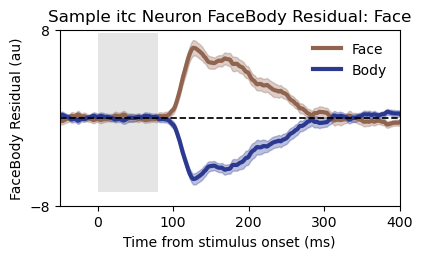

In [16]:
isample = 117
pref_cond = 0
plot_ylim = 8.0
fig_sz = np.array((4,2.5)) * 1

area = 'itc'
smooth_win = 1
plot_xlim = [-50,400]
plot_ylim = [-plot_ylim,plot_ylim]

m_plot([norm_res_itc[isample,indc1,:], norm_res_itc[isample,indc2,:]], [color_class1,color_class2], error_method='sem', 
       smooth_win=smooth_win, labels=res_plot_labels, plot_title=f'Sample {area} Neuron {myCond} Residual: {res_plot_labels[pref_cond]}', timepoints=time_stamps, figure_size=fig_sz)
plt.axhline(0, ls='--', color='k', lw=fig_sz[1]*.5)

plt.xlabel('Time from stimulus onset (ms)')
plt.xlim(plot_xlim)
plt.xticks([0,100,200,300,400])

plt.ylabel(f'{myCond} Residual (au)')
plt.ylim(plot_ylim)
plt.yticks([plot_ylim[0], plot_ylim[1]])

clear_output()
# plt.savefig(f'{FigDir}residual_sampleNeuron_{myCond}_{res_plot_labels[pref_cond]}_{area}_num{isample}.svg')

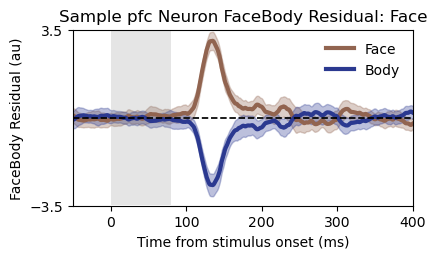

In [11]:
isample = 105
pref_cond = 0
plot_ylim = 3.5
fig_sz = np.array((4,2.5)) * 1

area = 'pfc'
smooth_win = 1
plot_xlim = [-50,400]
plot_ylim = [-plot_ylim,plot_ylim]

m_plot([norm_res_pfc[isample,indc1,:], norm_res_pfc[isample,indc2,:]], [color_class1,color_class2], error_method='sem', 
       smooth_win=smooth_win, labels=res_plot_labels, plot_title=f'Sample {area} Neuron {myCond} Residual: {res_plot_labels[pref_cond]}', timepoints=time_stamps, figure_size=fig_sz)

plt.axhline(0, ls='--', color='k', lw=fig_sz[1]*.5)

plt.xlabel('Time from stimulus onset (ms)')
plt.xlim(plot_xlim)
plt.xticks([0,100,200,300,400])

plt.ylabel(f'{myCond} Residual (au)')
plt.ylim(plot_ylim)
plt.yticks([plot_ylim[0], plot_ylim[1]])

clear_output()
# plt.savefig(f'{FigDir}residual_sampleNeuron_{myCond}_{res_plot_labels[pref_cond]}_{area}_num{isample}.svg')

# RSA

In [12]:
rsa_itc = np.zeros((cycle_num,time_stamps.shape[0])) * np.nan
rsa_pfc = np.copy(rsa_itc)

for icycle,tmp_idx in tqdm(enumerate(idx_rand)):
    rsa_itc[icycle] = compute_rsa(norm_res_itc[:,tmp_idx,:], conds_ls=[stim_num,stim_num])
    rsa_pfc[icycle] = compute_rsa(norm_res_pfc[:,tmp_idx,:], conds_ls=[stim_num,stim_num])


0it [00:00, ?it/s]

In [8]:
base_time_idx = (time_stamps>-50) & (time_stamps<50)
_, peak_raw_itc, onset_raw_itc, sol_raw_itc, _ = FindResp(rsa_itc, time_stamps, base_time_idx)
_, peak_raw_pfc, onset_raw_pfc, sol_raw_pfc, _ = FindResp(rsa_pfc, time_stamps, base_time_idx)

rsa_bs_itc = comp_bs_dist(rsa_itc)
rsa_bs_pfc = comp_bs_dist(rsa_pfc)

_, peak_bs_itc, onset_bs_itc, sol_bs_itc, _ = FindResp(rsa_bs_itc, time_stamps, base_time_idx)
_, peak_bs_pfc, onset_bs_pfc, sol_bs_pfc, _ = FindResp(rsa_bs_pfc, time_stamps, base_time_idx)


# Animacy

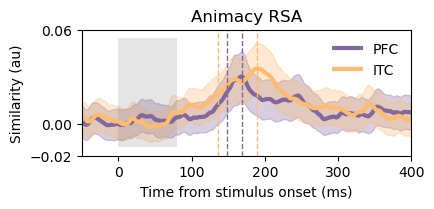

In [9]:
smooth_win = 2
plot_xlim = [-50,400]
plot_ylim = [-.02,.06]
fig_sz = np.array((4,2)) * 1

m_plot([rsa_pfc,rsa_itc], [color_pfc,color_itc], error_method='std', 
       smooth_win=smooth_win, labels=['PFC','ITC'], plot_title=f'{myCond} RSA', timepoints=time_stamps, figure_size=fig_sz)

if 1:
       plt.axvline(np.nanmedian(onset_raw_pfc), ls='--', color=color_pfc_n[:3], alpha=1, lw=fig_sz[1]*.5)
       plt.axvline(np.nanmedian(onset_raw_itc), ls='--', color=color_itc_n[:3], alpha=1, lw=fig_sz[1]*.5)
       plt.axvline(np.nanmedian(peak_raw_pfc), ls='--', color=color_pfc_n[:3], alpha=1, lw=fig_sz[1]*.5)
       plt.axvline(np.nanmedian(peak_raw_itc), ls='--', color=color_itc_n[:3], alpha=1, lw=fig_sz[1]*.5)
else:
       plt.axvline(np.nanmedian(onset_bs_pfc), ls='--', color=color_pfc_n[:3], alpha=1, lw=fig_sz[1]*.5)
       plt.axvline(np.nanmedian(onset_bs_itc), ls='--', color=color_itc_n[:3], alpha=1, lw=fig_sz[1]*.5)
       plt.axvline(np.nanmedian(peak_bs_pfc), ls='--', color=color_pfc_n[:3], alpha=1, lw=fig_sz[1]*.5)
       plt.axvline(np.nanmedian(peak_bs_itc), ls='--', color=color_itc_n[:3], alpha=1, lw=fig_sz[1]*.5)

plt.xlabel('Time from stimulus onset (ms)')
plt.xlim(plot_xlim)
plt.xticks([0,100,200,300,400])

plt.ylabel('Similarity (au)')
plt.ylim(plot_ylim)
plt.yticks([plot_ylim[0], 0, plot_ylim[1]])

clear_output()
# plt.savefig(f'{FigDir}residual_rsa_{myCond}_both.svg')

Onset ITC = 136.0 -+ 40.003402981202754
Onset PFC = 148.0 -+ 39.918132941040575
Onset Permutation p = 0.042759144817103655
Onset p (comp_means) = 0.8757793263560651
-----
Peak ITC = 189.0 -+ 32.36566400739399
Peak PFC = 168.5 -+ 39.27681484955929
Peak Permutation p = 0.07013859722805543
Peak p (comp_means) = 0.8886738864046893
-----
Solution ITC = 49.0 -+ 40.81111468188206
Solution PFC = 23.0 -+ 44.91571767717783
Solution Permutation p = 0.0007199856002879943
Solution p (comp_means) = 0.79252753806458


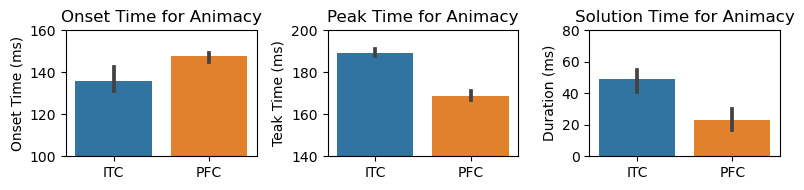

In [10]:
figure_size = np.array((8,2)) * 1
fig1, ax = plt.subplots(nrows=1, ncols=3, figsize=figure_size)
# error_method = 'se'
error_method = ('ci', 95)
estimator='median'
bar_xticks = ["ITC", "PFC"]

plt_onset = sns.barplot(ax=ax[0], data=[onset_raw_itc, onset_raw_pfc], estimator=estimator, errorbar=error_method)
ax[0].set_ylim([100,160])
ax[0].set_yticks([100,120,140,160])
ax[0].set_ylabel('Onset Time (ms)')
ax[0].set_title(f'Onset Time for {myCond}')
plt_onset.set(xticklabels=bar_xticks)

plt_peak = sns.barplot(ax=ax[1], data=[peak_raw_itc, peak_raw_pfc], estimator=estimator, errorbar=error_method)
ax[1].set_ylim([140,200])
ax[1].set_yticks([140,160,180,200])
ax[1].set_ylabel('Teak Time (ms)')
ax[1].set_title(f'Peak Time for {myCond}')
plt_peak.set(xticklabels=bar_xticks)

plt_sol = sns.barplot(ax=ax[2], data=[sol_raw_itc, sol_raw_pfc], estimator=estimator, errorbar=error_method)
ax[2].set_ylim([0,80])
ax[2].set_yticks([0,20,40,60,80])
ax[2].set_ylabel('Duration (ms)')
ax[2].set_title(f'Solution Time for {myCond}')
plt_sol.set(xticklabels=bar_xticks)

plt.tight_layout()

print(f'Onset ITC = {np.nanmedian(onset_raw_itc)} -+ {np.nanstd(onset_raw_itc)}')
print(f'Onset PFC = {np.nanmedian(onset_raw_pfc)} -+ {np.nanstd(onset_raw_pfc)}')
print(f"Onset Permutation p = {comp_permute_p(onset_raw_itc, onset_raw_pfc)}")
print(f"Onset p (comp_means) = {compare_means_bs(onset_raw_itc, onset_raw_pfc)}")
print(f"-----")
print(f'Peak ITC = {np.nanmedian(peak_raw_itc)} -+ {np.nanstd(peak_raw_itc)}')
print(f'Peak PFC = {np.nanmedian(peak_raw_pfc)} -+ {np.nanstd(peak_raw_pfc)}')
print(f"Peak Permutation p = {comp_permute_p(peak_raw_itc, peak_raw_pfc)}")
print(f"Peak p (comp_means) = {compare_means_bs(peak_raw_itc, peak_raw_pfc)}")
print(f"-----")
print(f'Solution ITC = {np.nanmedian(sol_raw_itc)} -+ {np.nanstd(sol_raw_itc)}')
print(f'Solution PFC = {np.nanmedian(sol_raw_pfc)} -+ {np.nanstd(sol_raw_pfc)}')
print(f"Solution Permutation p = {comp_permute_p(sol_raw_itc, sol_raw_pfc)}")
print(f"Solution p (comp_means) = {compare_means_bs(sol_raw_itc, sol_raw_pfc)}")

# plt.savefig(f'{FigDir}residual_rsa_{myCond}_stat_both.svg')

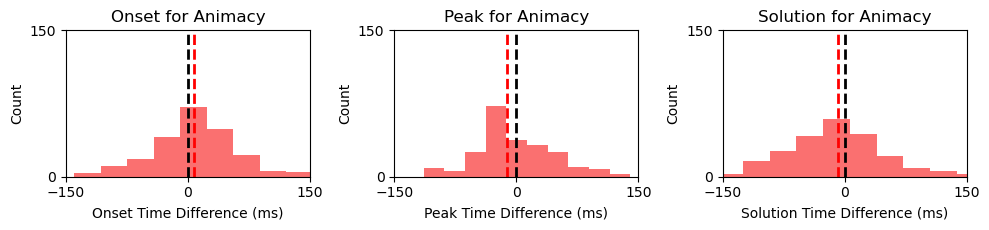

In [19]:
fig_sz = np.array((5,1.2)) * 2
plot_xlim = [-150,150]
plot_ylim = [0,150]

diffs_onset = onset_raw_pfc - onset_raw_itc
diffs_peak  = peak_raw_pfc - peak_raw_itc
diffs_sol   = sol_raw_pfc - sol_raw_itc

fig1, axs = plt.subplots(figsize=fig_sz, ncols=3, nrows=1)

axs[0].hist(diffs_onset, color=diff_color, edgecolor='none')
axs[0].axvline(0, color='k', ls='--', lw=fig_sz[0]/5)
axs[0].axvline(np.nanmedian(diffs_onset), color='r', ls='--', lw=fig_sz[0]/5)
axs[0].set_xlim(plot_xlim)
axs[0].set_xticks([plot_xlim[0], 0, plot_xlim[1]])
axs[0].set_xlabel('Onset Time Difference (ms)')
axs[0].set_ylim(plot_ylim)
axs[0].set_yticks(plot_ylim)
axs[0].set_ylabel('Count')
axs[0].set_title(f'Onset for {myCond}')

axs[1].hist(diffs_peak, color=diff_color, edgecolor='none')
axs[1].axvline(0, color='k', ls='--', lw=fig_sz[0]/5)
axs[1].axvline(np.nanmedian(diffs_peak), color='r', ls='--', lw=fig_sz[0]/5)
axs[1].set_xlim(plot_xlim)
axs[1].set_xticks([plot_xlim[0], 0, plot_xlim[1]])
axs[1].set_xlabel('Peak Time Difference (ms)')
axs[1].set_ylim(plot_ylim)
axs[1].set_yticks(plot_ylim)
axs[1].set_ylabel('Count')
axs[1].set_title(f'Peak for {myCond}')

axs[2].hist(diffs_sol, color=diff_color, edgecolor='none')
axs[2].axvline(0, color='k', ls='--', lw=fig_sz[0]/5)
axs[2].axvline(np.nanmedian(diffs_sol), color='r', ls='--', lw=fig_sz[0]/5)
axs[2].set_xlim(plot_xlim)
axs[2].set_xticks([plot_xlim[0], 0, plot_xlim[1]])
axs[2].set_xlabel('Solution Time Difference (ms)')
axs[2].set_ylim(plot_ylim)
axs[2].set_yticks(plot_ylim)
axs[2].set_ylabel('Count')
axs[2].set_title(f'Solution for {myCond}')

plt.tight_layout()
# plt.savefig(f'{FigDir}residual_rsa_{myCond}_stat_hist_both.svg')

Onset ITC = 73.0 -+ 8.19676613061517
Onset PFC = 86.0 -+ 11.89057504917235
Onset Permutation p = 1.999960000799984e-05
Onset p (comp_means) = 0.3333028402397016
-----
Peak ITC = 193.0 -+ 3.1428927757720273
Peak PFC = 167.0 -+ 3.768169316790317
Peak Permutation p = 1.999960000799984e-05
Peak p (comp_means) = 4.6629367034256575e-15
-----
Solution ITC = 115.0 -+ 8.464065217140048
Solution PFC = 81.0 -+ 12.281033140579012
Solution Permutation p = 1.999960000799984e-05
Solution p (comp_means) = 0.00043920764863591977


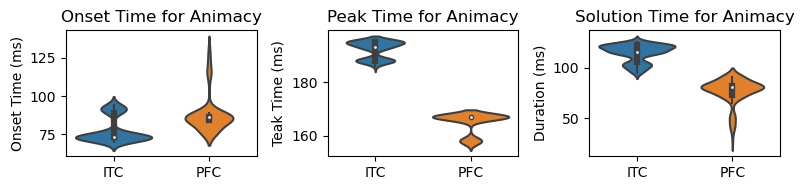

In [ ]:
figure_size = np.array((8,2)) * 1
fig1, ax = plt.subplots(nrows=1, ncols=3, figsize=figure_size)
error_method = 'sd'
estimator='median'
bar_xticks = ["ITC", "PFC"]

plt_onset = sns.violinplot(ax=ax[0], data=[onset_bs_itc, onset_bs_pfc], estimator=estimator, errorbar=error_method)
# ax[0].set_ylim([90,150])
# ax[0].set_yticks([90,120,150])
ax[0].set_ylabel('Onset Time (ms)')
ax[0].set_title(f'Onset Time for {myCond}')
plt_onset.set(xticklabels=bar_xticks)

plt_peak = sns.violinplot(ax=ax[1], data=[peak_bs_itc, peak_bs_pfc], estimator=estimator, errorbar=error_method)
# ax[1].set_ylim([160,220])
# ax[1].set_yticks([160,180,200,220])
ax[1].set_ylabel('Teak Time (ms)')
ax[1].set_title(f'Peak Time for {myCond}')
plt_peak.set(xticklabels=bar_xticks)

plt_sol = sns.violinplot(ax=ax[2], data=[sol_bs_itc, sol_bs_pfc], estimator=estimator, errorbar=error_method)
# ax[2].set_ylim([30,75])
# ax[2].set_yticks([30,45,60,75])
ax[2].set_ylabel('Duration (ms)')
ax[2].set_title(f'Solution Time for {myCond}')
plt_sol.set(xticklabels=bar_xticks)

plt.tight_layout()

print(f'Onset ITC = {np.nanmedian(onset_bs_itc)} -+ {np.nanstd(onset_bs_itc)}')
print(f'Onset PFC = {np.nanmedian(onset_bs_pfc)} -+ {np.nanstd(onset_bs_pfc)}')
print(f"Onset Permutation p = {comp_permute_p(onset_bs_itc, onset_bs_pfc)}")
print(f"Onset p (comp_means) = {compare_means_bs(onset_bs_itc, onset_bs_pfc)}")
print(f"-----")
print(f'Peak ITC = {np.nanmedian(peak_bs_itc)} -+ {np.nanstd(peak_bs_itc)}')
print(f'Peak PFC = {np.nanmedian(peak_bs_pfc)} -+ {np.nanstd(peak_bs_pfc)}')
print(f"Peak Permutation p = {comp_permute_p(peak_bs_itc, peak_bs_pfc)}")
print(f"Peak p (comp_means) = {compare_means_bs(peak_bs_itc, peak_bs_pfc)}")
print(f"-----")
print(f'Solution ITC = {np.nanmedian(sol_bs_itc)} -+ {np.nanstd(sol_bs_itc)}')
print(f'Solution PFC = {np.nanmedian(sol_bs_pfc)} -+ {np.nanstd(sol_bs_pfc)}')
print(f"Solution Permutation p = {comp_permute_p(sol_bs_itc, sol_bs_pfc)}")
print(f"Solution p (comp_means) = {compare_means_bs(sol_bs_itc, sol_bs_pfc)}")

# plt.savefig(f'{FigDir}residual_rsa_{myCond}_stat_both.svg')

# FaceBody

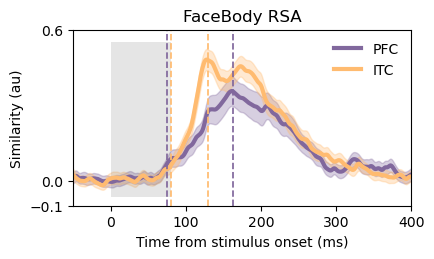

In [97]:
smooth_win = 2
plot_xlim = [-50,400]
plot_ylim = [-.1,.6]
fig_sz = np.array((4,2.5)) * 1

m_plot([rsa_pfc,rsa_itc], [color_pfc,color_itc], error_method='std', 
       smooth_win=smooth_win, labels=['PFC','ITC'], plot_title=f'{myCond} RSA', timepoints=time_stamps, figure_size=fig_sz)

if 1:
       plt.axvline(np.nanmedian(onset_raw_pfc), ls='--', color=color_pfc_n[:3], alpha=1, lw=fig_sz[1]*.5)
       plt.axvline(np.nanmedian(onset_raw_itc), ls='--', color=color_itc_n[:3], alpha=1, lw=fig_sz[1]*.5)
       plt.axvline(np.nanmedian(peak_raw_pfc), ls='--', color=color_pfc_n[:3], alpha=1, lw=fig_sz[1]*.5)
       plt.axvline(np.nanmedian(peak_raw_itc), ls='--', color=color_itc_n[:3], alpha=1, lw=fig_sz[1]*.5)
else:
       plt.axvline(np.nanmedian(onset_bs_pfc), ls='--', color=color_pfc_n[:3], alpha=1, lw=fig_sz[1]*.5)
       plt.axvline(np.nanmedian(onset_bs_itc), ls='--', color=color_itc_n[:3], alpha=1, lw=fig_sz[1]*.5)
       plt.axvline(np.nanmedian(peak_bs_pfc), ls='--', color=color_pfc_n[:3], alpha=1, lw=fig_sz[1]*.5)
       plt.axvline(np.nanmedian(peak_bs_itc), ls='--', color=color_itc_n[:3], alpha=1, lw=fig_sz[1]*.5)

plt.xlabel('Time from stimulus onset (ms)')
plt.xlim(plot_xlim)
plt.xticks([0,100,200,300,400])

plt.ylabel('Similarity (au)')
plt.ylim(plot_ylim)
plt.yticks([plot_ylim[0], 0, plot_ylim[1]])

clear_output()
# plt.savefig(f'{FigDir}residual_rsa_{myCond}_both.svg')

Onset ITC = 80.0 -+ 8.983187445159132
Onset PFC = 75.5 -+ 10.66175768450385
Onset Permutation p = 5.999880002399952e-05
Onset p (comp_means) = 0.7516305276849895
-----
Peak ITC = 129.0 -+ 21.97843411482914
Peak PFC = 163.0 -+ 12.986181207994283
Peak Permutation p = 1.999960000799984e-05
Peak p (comp_means) = 0.19119141177055798
-----
Solution ITC = 55.0 -+ 23.460257153684378
Solution PFC = 88.0 -+ 16.006204880437966
Solution Permutation p = 1.999960000799984e-05
Solution p (comp_means) = 0.18425644935631347


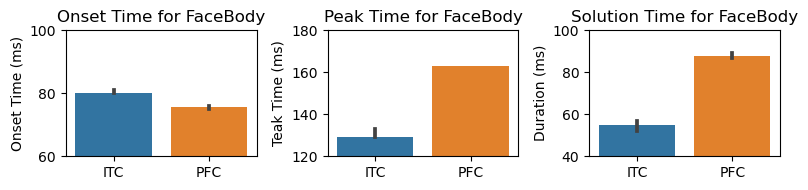

In [100]:
figure_size = np.array((8,2)) * 1
fig1, ax = plt.subplots(nrows=1, ncols=3, figsize=figure_size)
# error_method = 'se'
error_method = ('ci', 95)
estimator='median'
bar_xticks = ["ITC", "PFC"]

plt_onset = sns.barplot(ax=ax[0], data=[onset_raw_itc, onset_raw_pfc], estimator=estimator, errorbar=error_method)
ax[0].set_ylim([60,100])
ax[0].set_yticks([60,80,100])
ax[0].set_ylabel('Onset Time (ms)')
ax[0].set_title(f'Onset Time for {myCond}')
plt_onset.set(xticklabels=bar_xticks)

plt_peak = sns.barplot(ax=ax[1], data=[peak_raw_itc, peak_raw_pfc], estimator=estimator, errorbar=error_method)
ax[1].set_ylim([120,180])
ax[1].set_yticks([120,140,160,180])
ax[1].set_ylabel('Teak Time (ms)')
ax[1].set_title(f'Peak Time for {myCond}')
plt_peak.set(xticklabels=bar_xticks)

plt_sol = sns.barplot(ax=ax[2], data=[sol_raw_itc, sol_raw_pfc], estimator=estimator, errorbar=error_method)
ax[2].set_ylim([40,100])
ax[2].set_yticks([40,60,80,100])
ax[2].set_ylabel('Duration (ms)')
ax[2].set_title(f'Solution Time for {myCond}')
plt_sol.set(xticklabels=bar_xticks)

plt.tight_layout()

print(f'Onset ITC = {np.nanmedian(onset_raw_itc)} -+ {np.nanstd(onset_raw_itc)}')
print(f'Onset PFC = {np.nanmedian(onset_raw_pfc)} -+ {np.nanstd(onset_raw_pfc)}')
print(f"Onset Permutation p = {comp_permute_p(onset_raw_itc, onset_raw_pfc)}")
print(f"Onset p (comp_means) = {compare_means_bs(onset_raw_itc, onset_raw_pfc)}")
print(f"-----")
print(f'Peak ITC = {np.nanmedian(peak_raw_itc)} -+ {np.nanstd(peak_raw_itc)}')
print(f'Peak PFC = {np.nanmedian(peak_raw_pfc)} -+ {np.nanstd(peak_raw_pfc)}')
print(f"Peak Permutation p = {comp_permute_p(peak_raw_itc, peak_raw_pfc)}")
print(f"Peak p (comp_means) = {compare_means_bs(peak_raw_itc, peak_raw_pfc)}")
print(f"-----")
print(f'Solution ITC = {np.nanmedian(sol_raw_itc)} -+ {np.nanstd(sol_raw_itc)}')
print(f'Solution PFC = {np.nanmedian(sol_raw_pfc)} -+ {np.nanstd(sol_raw_pfc)}')
print(f"Solution Permutation p = {comp_permute_p(sol_raw_itc, sol_raw_pfc)}")
print(f"Solution p (comp_means) = {compare_means_bs(sol_raw_itc, sol_raw_pfc)}")

# plt.savefig(f'{FigDir}residual_rsa_{myCond}_stat_both.svg')

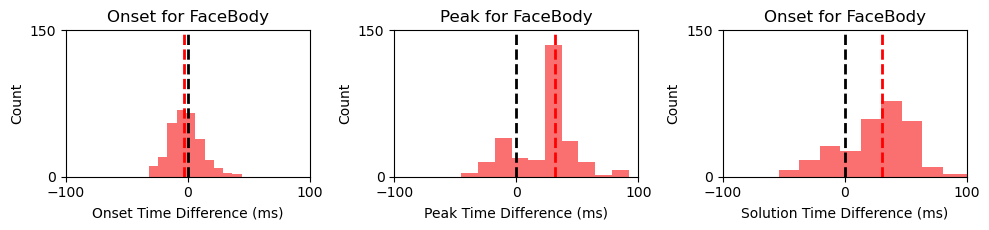

In [ ]:
fig_sz = np.array((5,1.2)) * 2
plot_xlim = [-100,100]
plot_ylim = [0,150]

diffs_onset = onset_raw_pfc - onset_raw_itc
diffs_peak  = peak_raw_pfc - peak_raw_itc
diffs_sol   = sol_raw_pfc - sol_raw_itc

fig1, axs = plt.subplots(figsize=fig_sz, ncols=3, nrows=1)

axs[0].hist(diffs_onset, color=diff_color, edgecolor='none')
axs[0].axvline(0, color='k', ls='--', lw=fig_sz[0]/5)
axs[0].axvline(np.nanmedian(diffs_onset), color='r', ls='--', lw=fig_sz[0]/5)
axs[0].set_xlim(plot_xlim)
axs[0].set_xticks([plot_xlim[0], 0, plot_xlim[1]])
axs[0].set_xlabel('Onset Time Difference (ms)')
axs[0].set_ylim(plot_ylim)
axs[0].set_yticks(plot_ylim)
axs[0].set_ylabel('Count')
axs[0].set_title(f'Onset for {myCond}')

axs[1].hist(diffs_peak, color=diff_color, edgecolor='none')
axs[1].axvline(0, color='k', ls='--', lw=fig_sz[0]/5)
axs[1].axvline(np.nanmedian(diffs_peak), color='r', ls='--', lw=fig_sz[0]/5)
axs[1].set_xlim(plot_xlim)
axs[1].set_xticks([plot_xlim[0], 0, plot_xlim[1]])
axs[1].set_xlabel('Peak Time Difference (ms)')
axs[1].set_ylim(plot_ylim)
axs[1].set_yticks(plot_ylim)
axs[1].set_ylabel('Count')
axs[1].set_title(f'Peak for {myCond}')

axs[2].hist(diffs_sol, color=diff_color, edgecolor='none')
axs[2].axvline(0, color='k', ls='--', lw=fig_sz[0]/5)
axs[2].axvline(np.nanmedian(diffs_sol), color='r', ls='--', lw=fig_sz[0]/5)
axs[2].set_xlim(plot_xlim)
axs[2].set_xticks([plot_xlim[0], 0, plot_xlim[1]])
axs[2].set_xlabel('Solution Time Difference (ms)')
axs[2].set_ylim(plot_ylim)
axs[2].set_yticks(plot_ylim)
axs[2].set_ylabel('Count')
axs[2].set_title(f'Solution for {myCond}')

plt.tight_layout()
# plt.savefig(f'{FigDir}residual_rsa_{myCond}_stat_hist_both.svg')

Onset ITC = 70.0 -+ 0.8302348708819706
Onset PFC = 69.0 -+ 0.20730412441627882
Onset Permutation p = 1.999960000799984e-05
Onset p (comp_means) = 0.01855179694544673
-----
Peak ITC = 127.0 -+ 6.756653525518777
Peak PFC = 163.0 -+ 0.0
Peak Permutation p = 1.999960000799984e-05
Peak p (comp_means) = 2.220446049250313e-16
-----
Solution ITC = 57.0 -+ 6.792982804675379
Solution PFC = 94.0 -+ 0.20730412441627882
Solution Permutation p = 1.999960000799984e-05
Solution p (comp_means) = 0.0


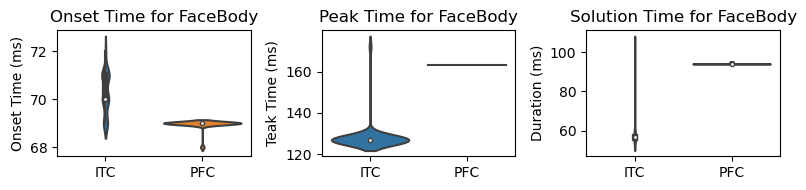

In [ ]:
figure_size = np.array((8,2)) * 1
fig1, ax = plt.subplots(nrows=1, ncols=3, figsize=figure_size)
error_method = 'sd'
estimator='median'
bar_xticks = ["ITC", "PFC"]

plt_onset = sns.violinplot(ax=ax[0], data=[onset_bs_itc, onset_bs_pfc], estimator=estimator, errorbar=error_method)
# ax[0].set_ylim([90,150])
# ax[0].set_yticks([90,120,150])
ax[0].set_ylabel('Onset Time (ms)')
ax[0].set_title(f'Onset Time for {myCond}')
plt_onset.set(xticklabels=bar_xticks)

plt_peak = sns.violinplot(ax=ax[1], data=[peak_bs_itc, peak_bs_pfc], estimator=estimator, errorbar=error_method)
# ax[1].set_ylim([160,220])
# ax[1].set_yticks([160,180,200,220])
ax[1].set_ylabel('Teak Time (ms)')
ax[1].set_title(f'Peak Time for {myCond}')
plt_peak.set(xticklabels=bar_xticks)

plt_sol = sns.violinplot(ax=ax[2], data=[sol_bs_itc, sol_bs_pfc], estimator=estimator, errorbar=error_method)
# ax[2].set_ylim([30,75])
# ax[2].set_yticks([30,45,60,75])
ax[2].set_ylabel('Duration (ms)')
ax[2].set_title(f'Solution Time for {myCond}')
plt_sol.set(xticklabels=bar_xticks)

plt.tight_layout()

print(f'Onset ITC = {np.nanmedian(onset_bs_itc)} -+ {np.nanstd(onset_bs_itc)}')
print(f'Onset PFC = {np.nanmedian(onset_bs_pfc)} -+ {np.nanstd(onset_bs_pfc)}')
print(f"Onset Permutation p = {comp_permute_p(onset_bs_itc, onset_bs_pfc)}")
print(f"Onset p (comp_means) = {compare_means_bs(onset_bs_itc, onset_bs_pfc)}")
print(f"-----")
print(f'Peak ITC = {np.nanmedian(peak_bs_itc)} -+ {np.nanstd(peak_bs_itc)}')
print(f'Peak PFC = {np.nanmedian(peak_bs_pfc)} -+ {np.nanstd(peak_bs_pfc)}')
print(f"Peak Permutation p = {comp_permute_p(peak_bs_itc, peak_bs_pfc)}")
print(f"Peak p (comp_means) = {compare_means_bs(peak_bs_itc, peak_bs_pfc)}")
print(f"-----")
print(f'Solution ITC = {np.nanmedian(sol_bs_itc)} -+ {np.nanstd(sol_bs_itc)}')
print(f'Solution PFC = {np.nanmedian(sol_bs_pfc)} -+ {np.nanstd(sol_bs_pfc)}')
print(f"Solution Permutation p = {comp_permute_p(sol_bs_itc, sol_bs_pfc)}")
print(f"Solution p (comp_means) = {compare_means_bs(sol_bs_itc, sol_bs_pfc)}")

# plt.savefig(f'{FigDir}residual_rsa_{myCond}_stat_both.svg')